# Processing CMIP6 data in Zarr format with DaskHub & Amazon EKS

This notebook demonstrates how to work with the CMIP6 Zarr data available as part of the AWS Open Data Program (https://registry.opendata.aws/cmip6/).
This notebook is adapted from [this](https://github.com/awslabs/amazon-asdi/blob/main/examples/dask/notebooks/cmip6_zarr.ipynb) notebook, with the only differences being how the Dask cluster is configured.  In the original notebook, Amazon ECS on AWS Fargate is used to run Dask, while the Jupyter notebook is run on Amazon SageMaker.  In this notebook, the expectation is that it is run on an Amazon EKS cluster running the DaskHub Helm chart.  

## Python Imports

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import s3fs
import dask
from dask.distributed import performance_report, progress
from dask_gateway import GatewayCluster

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

## Create Dask Cluster, Scale It Out, and Create a Dask Client

In [2]:
# Specifying a bit less than whole number values for cpu cores and memory allows Dask worker pods to be packed more tightly onto 
# the underlying EC2 instances.
cluster = GatewayCluster(worker_cores=0.8, worker_memory=3.3)
cluster.scale(32)
client = cluster.get_client()
# It will take a few minutes for the underlying EC2 instances to be created and for the Dask Workers to be scheduled onto those EC2 instances.
# Running the cluster command as you see below will provide an updated view of the number of workers that have been successfully brought online.
cluster

## Open 2-m air temperature for a single ensemble member from the GFDL-ESM4

In [3]:
@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 50})
    return s3fs.S3Map(path, s3=fs)

In [4]:
%%time
files_mapper = [s3open('s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp119/r1i1p1f1/day/tas/gr1/v20180701/')]
ds = xr.open_mfdataset(files_mapper, engine='zarr', parallel=True)

CPU times: user 96.5 ms, sys: 12.5 ms, total: 109 ms
Wall time: 5.9 s


In [5]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 6.51



<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 31390)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(15695, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(421, 180, 288), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
 

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

## Convert units to F from K

In [6]:
ds['tas'] = (ds.tas - 273.15) * 9.0 / 5.0 + 32.0
ds.tas.attrs['units'] = 'F'

## Calculate the mean 2-m air temperature for all times

In [7]:
# calculates the mean along the time dimension
temp_mean = ds['tas'].mean(dim='time')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [8]:
temp_mean = temp_mean.persist()
progress(temp_mean)

VBox()

### Plot Average Surface Temperature

Text(0.5, 1.0, '2015-2100 Mean 2-m Air Temperature')

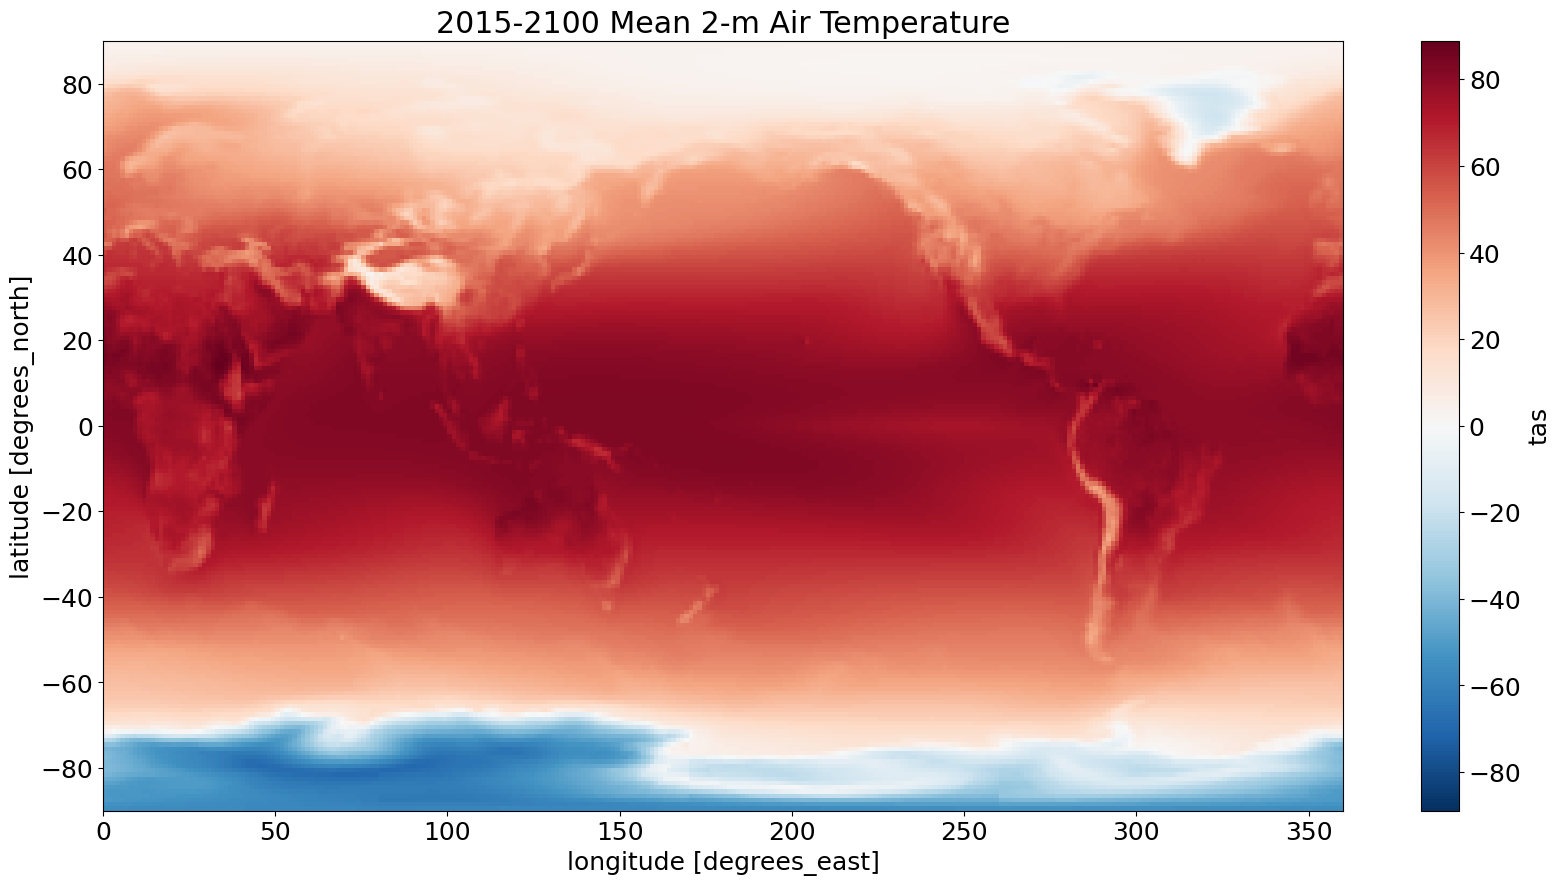

In [9]:
temp_mean.compute()
temp_mean.plot(figsize=(20, 10))
plt.title('2015-2100 Mean 2-m Air Temperature')

### Repeat for standard deviation

In [10]:
temp_std = ds['tas'].std(dim='time')

In [11]:
%time temp_std = temp_std.compute()

CPU times: user 30.7 ms, sys: 7.8 ms, total: 38.5 ms
Wall time: 21.2 s


Text(0.5, 1.0, '2015-2100 Standard Deviation 2-m Air Temperature')

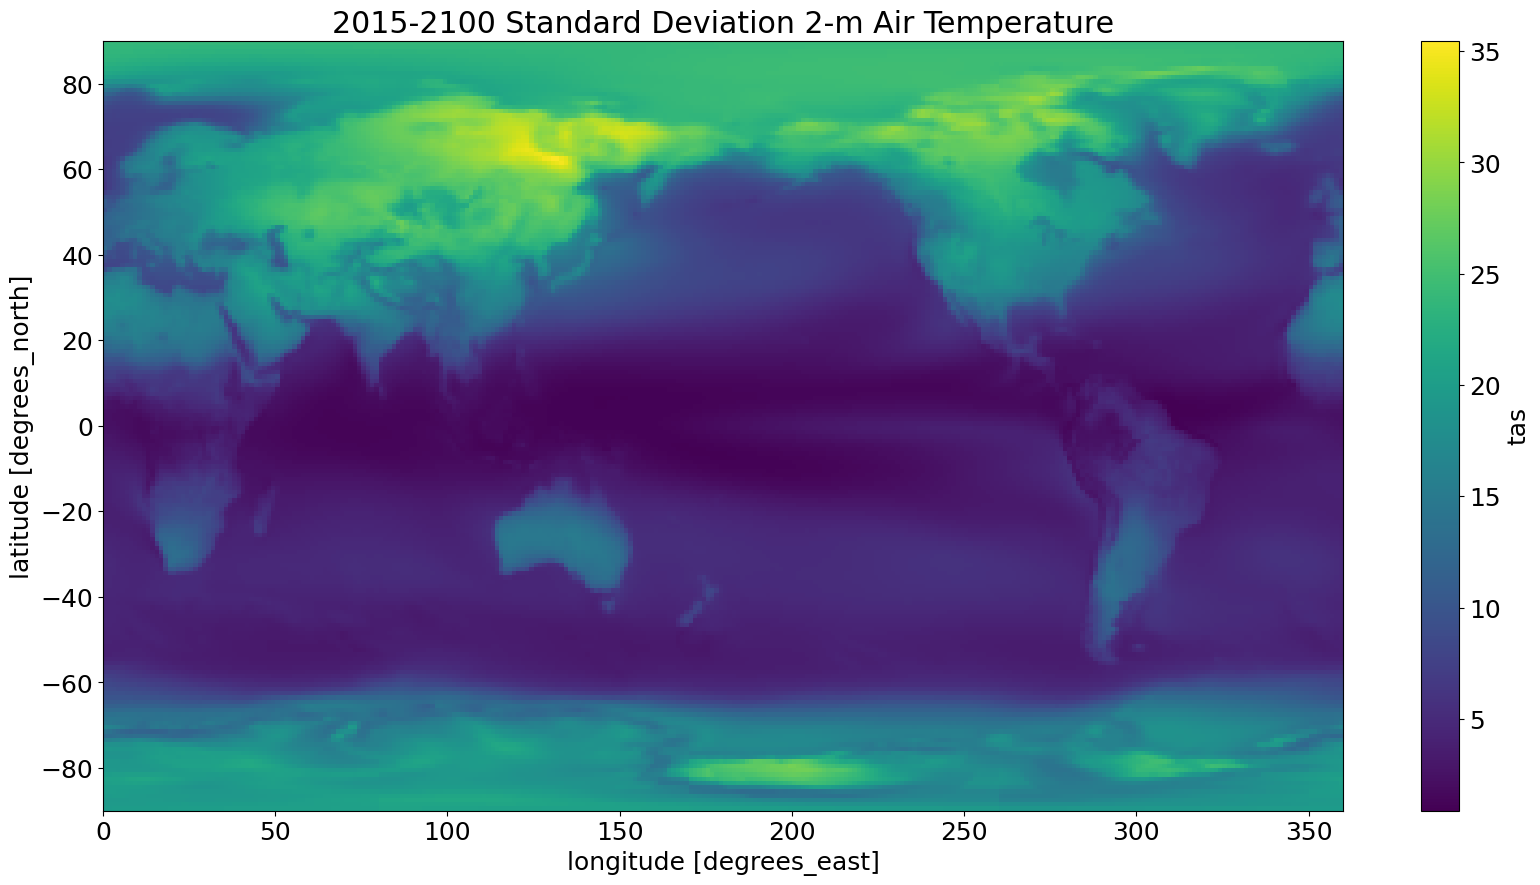

In [12]:
temp_std.plot(figsize=(20, 10))
plt.title('2015-2100 Standard Deviation 2-m Air Temperature')

## Plot temperature time series for points

In [13]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61}]

In [14]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'tas' : var_name}).drop(('lat', 'lon', 'height', 'lat_bnds', 'lon_bnds'))

    ds_locs = xr.merge([ds_locs, ds2], compat='override')

ds_locs.data_vars

Data variables:
    Santa Barbara     (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Colorado Springs  (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Honolulu          (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Seattle           (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>

### Convert to dataframe

In [15]:
df_f = ds_locs.to_dataframe()
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle
count,62780.000000,62780.000000,62780.000000,62780.000000
mean,61.857613,49.708950,75.883865,46.186607
std,11.264393,18.002874,3.517406,11.514654
min,30.185278,-3.966026,62.430756,-3.104340
25%,52.528065,35.121765,73.393410,37.788750
50%,60.398972,47.668564,75.938087,45.599756
75%,71.497169,65.013535,78.844604,55.601765
max,93.166054,89.571434,84.897247,77.280922


## Plot the entire time series of temperatures

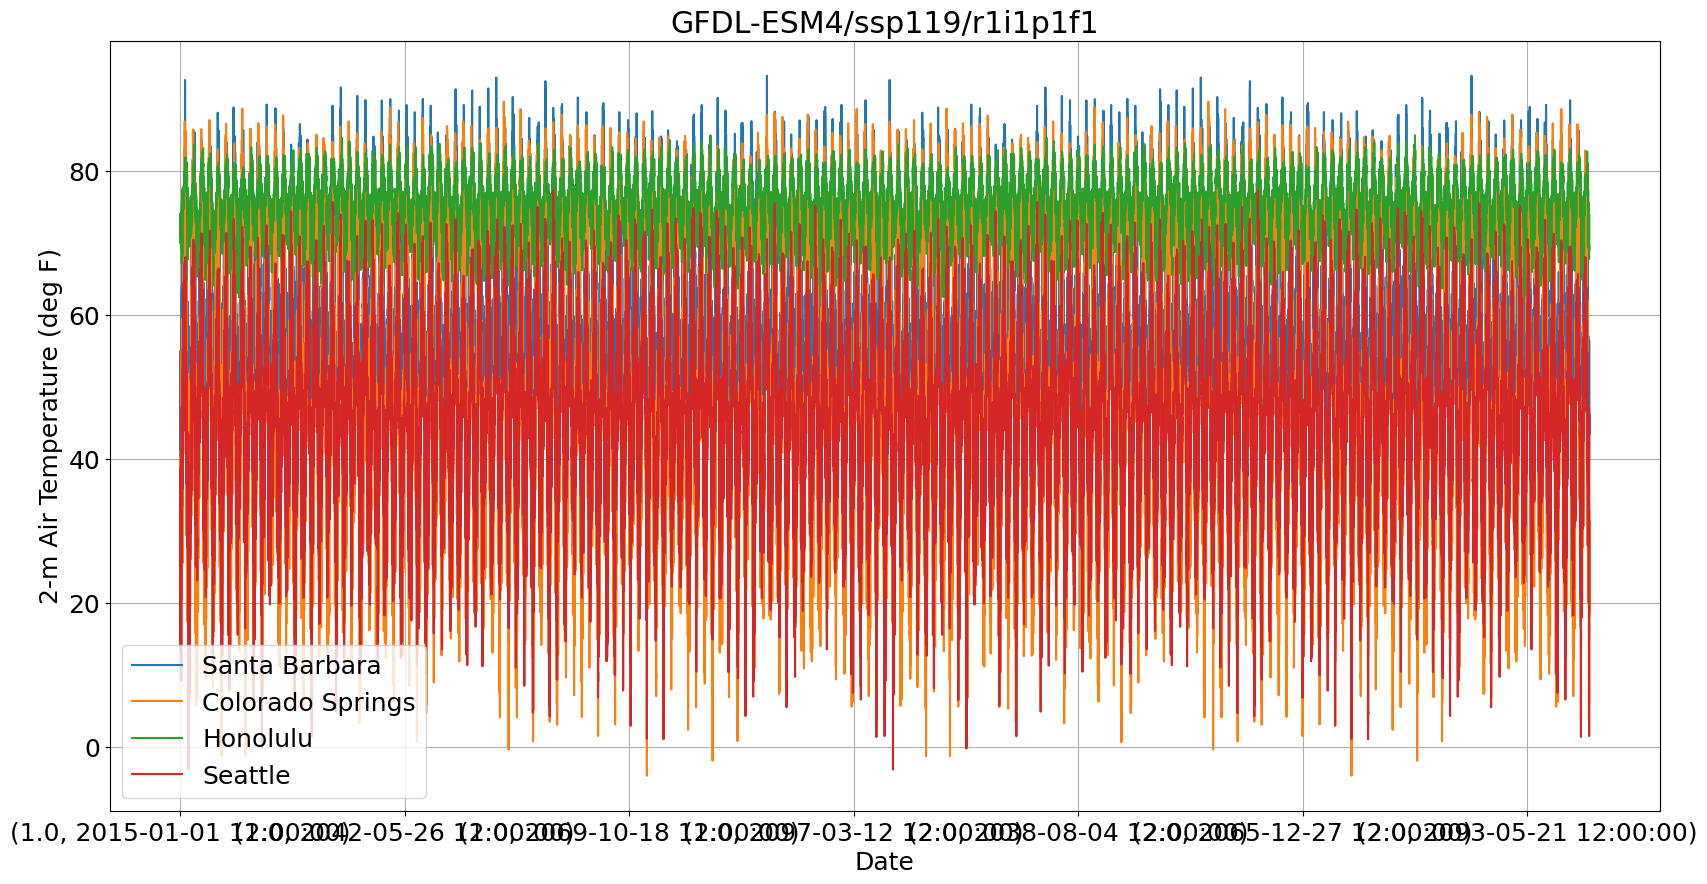

In [16]:
ax = df_f.plot(figsize=(20, 10), title="GFDL-ESM4/ssp119/r1i1p1f1", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()

## Cluster shut down

To save on cost it's important to shut down the cluster when we're done.

In [17]:
cluster.shutdown()